In [45]:
import numpy as np
import copy
import os
import pickle
import frogress
from Moments_analysis import moments_map, make_covariance
import math
import cosmolopy.distance as cd
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
        try:
            with open(name + '.pkl', 'rb') as f:
                return pickle.load(f)#, encoding='latin1')
        except:
            with open(name + '.pkl', 'rb') as f:
                return pickle.load(f, encoding='latin1')
    
def covariance_jck(vec,jk_r,type_cov):

  #  Covariance estimation
    len_w = len(vec[:,0])
    jck = len(vec[0,:])
    
    err = np.zeros(len_w)
    mean = np.zeros(len_w)
    cov = np.zeros((len_w,len_w))
    corr = np.zeros((len_w,len_w))
    
    mean = np.zeros(len_w)
    for i in range(jk_r):
        mean += vec[:,i]
    mean = mean/jk_r
    
    if type_cov=='jackknife':
        fact=(jk_r-1.)/(jk_r)

    elif type_cov=='bootstrap':
        fact=1./(jk_r-1)
    
    for i in range(len_w):
        for j in range(len_w):
            for k in range(jck):
                cov[i,j] += (vec[i,k]- mean[i])*(vec[j,k]- mean[j])*fact

    for ii in range(len_w):
        err[ii]=np.sqrt(cov[ii,ii])

  #compute correlation
    for i in range(len_w):
        for j in range(len_w):
            corr[i,j]=cov[i,j]/(np.sqrt(cov[i,i]*cov[j,j]))


    return {'cov' : cov,
          'err' : err,
          'corr':corr,
          'mean':mean}

    
# Fix a cosmology in case we want to apply a scale cut to the covariance matrix ***
cosmo = {'omega_M_0':0.28 , 
                     'omega_lambda_0':1 - 0.28 ,
                     'omega_k_0': 0.0, 
                     'omega_b_0' : 0.047 ,
                     'h':0.7 ,
                     'sigma_8' :  0.82,
                     'n': 0.97}
    
# this cuts the scales
def cut_scales(bi, physical_scale_cut=  24., mean_z =0):
    zzm=0.
    min_theta_rp=0.
    for bx in bi:
        zzm+=mean_z[bx-1]
    min_theta_rp=(physical_scale_cut/((1.+zzm*1./len(bi))*cd.comoving_distance(1.*zzm/len(bi),**cosmo)*(2*math.pi)/360)*60)
    return min_theta_rp




def make_covariance(mapp, num_real, scales, bins_dictionary):
    '''
    This routine create a covariance matrix from a list of FLASK moments.
    mapp: list of flask moments.
    num_real: number of realisations
    scales: smoothing scales
    bins_dictionary: it informs the code about the correlation and scales that needs to be included.
    
    
    '''
    
    # fiducial cosmology for the scale cut conversion.
    cosmo_scale = {'omega_M_0':0.28 , 
                     'omega_lambda_0':1 - 0.28 ,
                     'omega_k_0': 0.0, 
                     'omega_b_0' : 0.047 ,
                     'h':0.7 ,
                     'sigma_8' :  0.82,
                     'n': 0.97}
    
    import numpy as np
    
    # setup bins ************************************
    bins = []
    len_v = 0
    
    # this bit appends the bins and apply scale cut if needed
    for key in bins_dictionary.keys():
        for bi in bins_dictionary[key]['bins']:
            bins.append(bi)

            try:
                # scale cut ***
                zzm=0.
                min_theta_rp=0.
                if bins_dictionary[key]['scale_cut'] != None:
                    # we take the mean of the <z> of the tomographic bins involved. We use this redshift
                    # to convert a cut from physical scales to angular scales.
                    for bx in bi:
                        zzm += bins_dictionary[key]['Nz_mean'][bx]
                    min_theta_rp=(bins_dictionary[key]['scale_cut']/((1.+zzm/len(bi))*cd.comoving_distance(zzm/len(bi),**cosmo_scale)*(2*math.pi)/360)*60)
                    mask_scales = (np.array(scales)>min_theta_rp) 
                    len_v+= len(np.array(scales[mask_scales]))
                else:
                    len_v += len(np.array(scales))
                    
            except:
                len_v += len(np.array(scales))
    
    # now we can initialise the vector holding the moments from different FLASK simulations.
    vector = np.zeros((num_real,len_v))
    for jk in range(num_real):
        count=0
        for key in bins_dictionary.keys():
            for bi in bins_dictionary[key]['bins']:
                # binx: label of the bins in the format from FLASK
                binx = '_'.join([str(l) for l in bi])
                mask_scales = scales == scales
                try:
                    # scale cut ***
                    zzm=0.
                    min_theta_rp=0.
                    if bins_dictionary[key]['scale_cut'] != None:
                        # we take the mean of the <z> of the tomographic bins involved. We use this redshift
                        # to convert a cut from physical scales to angular scales.
                        for bx in bi:
                            zzm += bins_dictionary[key]['Nz_mean'][bx]
                        min_theta_rp=(bins_dictionary[key]['scale_cut']/((1.+zzm/len(bi))*cd.comoving_distance(zzm/len(bi),**cosmo_scale)*(2*math.pi)/360)*60)
                        mask_scales =np.array(scales)>min_theta_rp   
                        
                except:
                    pass
                mask = np.in1d(mapp[0].conf['smoothing_scales'],np.array(scales)[mask_scales])
                lent = len(mapp[0].conf['smoothing_scales'][mask])
                vector[jk,count:(count+lent)] = mapp[jk].moments[key][binx][mask]
                count+=lent
                
    cov_dict = covariance_jck(vector.T,num_real,"bootstrap")
    
    # the routine also gives back a dictionary with the diagonal elements of the covariance divided per bin combinations.
    err_dict_plot = dict()
    count = 0
    for key in bins_dictionary.keys():
        for bi in bins_dictionary[key]['bins']:
            # binx: label of the bins in the format from FLASK
            binx = '_'.join([str(l) for l in bi])
            mask_scales = scales == scales
            try:
                # scale cut ***
                zzm=0.
                min_theta_rp=0.
                if bins_dictionary[key]['scale_cut'] != None:
                    # we take the mean of the <z> of the tomographic bins involved. We use this redshift
                    # to convert a cut from physical scales to angular scales.
                    for bx in bi:
                        zzm += bins_dictionary[key]['Nz_mean'][bx]
                    min_theta_rp=(bins_dictionary[key]['scale_cut']/((1.+zzm/len(bi))*cd.comoving_distance(zzm/len(bi),**cosmo_scale)*(2*math.pi)/360)*60)
                    mask_scales =np.array(scales)>min_theta_rp
            except:
                pass
            mask = np.in1d(mapp[0].conf['smoothing_scales'],np.array(scales)[mask_scales])
            lent = len(mapp[0].conf['smoothing_scales'][mask])
            err_dict_plot[key+'_'+binx] = cov_dict['cov'][count:(count+lent),:][:,count:(count+lent)]
            count +=lent
    return cov_dict,vector,err_dict_plot



# Load moments measurements for the covariance matrix estimation

In [2]:
output = '/global/cscratch1/sd/mgatti/Mass_Mapping/moments/PKDGRAV_tests/'
N_rel = 12
label = '__fid'

mapp = []
bins_WL = [2]
i=0
for ii in frogress.bar(range(N_rel)):
    if os.path.exists(output+'moments_seed'+str(label)+'_'+str(ii+1)+'.pkl'):
        mute = load_obj(output+'moments_seed'+str(label)+'_'+str(ii+1))
        mapp.append(copy.deepcopy(mute))
        
        mapp[i].moments['nnn'] = dict()
        mapp[i].moments['enn'] = dict()
        mapp[i].moments['eee'] = dict()
        mapp[i].moments['nee'] = dict()

        if i == 0 :
            mapp_ave = copy.copy(mute)
            for key in mapp_ave.moments.keys():
                for key2 in mapp_ave.moments[key].keys():
                    mapp_ave.moments[key][key2] = mapp_ave.moments[key][key2]/N_rel
                
        else:
            for key in mute.moments.keys():
                for key2 in mute.moments[key].keys():
                    mapp_ave.moments[key][key2] += mute.moments[key][key2]/N_rel



        for b1 in bins_WL:
            # noise subtraction
            binx = '{0}_{0}'.format(b1)

            mapp[i].moments['kEkE'][binx] -= mapp[i].moments['kNkN'][binx]
            mapp[i].moments['kBkB'][binx] -= mapp[i].moments['kNkN'][binx]

                                        
        # third moments ****************************
        for j,binx1 in enumerate(bins_WL):
            for m,binx2 in enumerate(bins_WL):
                for k,binx3 in enumerate(bins_WL):
                    #k = copy.copy(m)
                    try:
                        # I save them 
                        binx = '{0}_{1}_{2}'.format(m, j, k)
                        eee = copy.copy(mapp[i].moments['kEkE']['{0}_{1}_{2}'.format(m, j, k)])
                        enn = copy.copy(mapp[i].moments['kEkN']['{0}_{1}_{2}'.format(m, j, k)])
                        enn += mapp[i].moments['kEkN']['{0}_{1}_{2}'.format(k, m, j)]
                        enn += mapp[i].moments['kEkN']['{0}_{1}_{2}'.format(j, m, k)]
                        nee =  copy.copy(mapp[i].moments['kNkE']['{0}_{1}_{2}'.format(m, j, k)])
                        nee += mapp[i].moments['kNkE']['{0}_{1}_{2}'.format(k, m, j)]
                        nee += mapp[i].moments['kNkE']['{0}_{1}_{2}'.format(j, m, k)]
                        nnn =  copy.copy(mapp[i].moments['kNkN']['{0}_{1}_{2}'.format(m, j, k)])
                        
                        #. This bit it's if you want to add theoretical modelling uncertainties; for now let's set it to 0 ********
                        u = 0* eee
                        #binx_t = '{0}_{1}_{2}'.format(m+1, j+1, k+1)
                        #dd = (theo_plot_gm[binx_t]-theo_plot[binx_t])
                        #c = np.zeros((len(dd),len(dd)))
                        #for h in range(len(dd)):
                        #    c[h,h] = dd[h]**2
                        #u = np.random.multivariate_normal(np.zeros(len(dd)),c,1)[0]

                        mapp[i].moments['kEkE'][binx] = copy.deepcopy(eee-enn) + u
                        mapp[i].moments['nnn'][binx] = copy.deepcopy(nnn)
                        mapp[i].moments['enn'][binx] = copy.deepcopy(enn)
                        mapp[i].moments['nee'][binx] = copy.deepcopy(nee)
                        mapp[i].moments['eee'][binx] = copy.deepcopy(eee)
                    except:
                        pass
                    
                    
        try:
            bins_weird = [[1,2,3],[1,2,4],[1,3,4],[2,3,4]]

            for b in  bins_weird:
                m = b[0]
                j = b[0]
                k = b[0]
                # I save them 
                binx = '{0}_{1}_{2}'.format(m, j, k)
                eee = copy.copy(mapp[i].moments['kEkE']['{0}_{1}_{2}'.format(m, j, k)])
                enn = copy.copy(mapp[i].moments['kEkN']['{0}_{1}_{2}'.format(m, j, k)])
                enn += mapp[i].moments['kEkN']['{0}_{1}_{2}'.format(k, m, j)]
                enn += mapp[i].moments['kEkN']['{0}_{1}_{2}'.format(j, m, k)]
                nee =  copy.copy(mapp[i].moments['kNkE']['{0}_{1}_{2}'.format(m, j, k)])
                nee += mapp[i].moments['kNkE']['{0}_{1}_{2}'.format(k, m, j)]
                nee += mapp[i].moments['kNkE']['{0}_{1}_{2}'.format(j, m, k)]
                nnn =  copy.copy(mapp[i].moments['kNkN']['{0}_{1}_{2}'.format(m, j, k)])

                #binx_t = '{0}_{1}_{2}'.format(m+1, j+1, k+1)
                #dd = (theo_plot_gm[binx_t]-theo_plot[binx_t])
                #c = np.zeros((len(dd),len(dd)))
                #for h in range(len(dd)):
                #    c[h,h] = dd[h]**2
                #u = np.random.multivariate_normal(np.zeros(len(dd)),c,1)[0]
                u = eee*0. 

                mapp[i].moments['kEkE'][binx] = copy.deepcopy(eee-enn) + u
                mapp[i].moments['nnn'][binx] = copy.deepcopy(nnn)
                mapp[i].moments['enn'][binx] = copy.deepcopy(enn)
                mapp[i].moments['nee'][binx] = copy.deepcopy(nee)
                mapp[i].moments['eee'][binx] = copy.deepcopy(eee)
        except:
            pass
        
        i+=1  
    else:
        print ('missing '+str(ii+1))

print ('done')

100.0% | [##########] | Progress: 12 / 12 | Time: 0.2s | ETA: --0sdone


# estimate covariance matrix

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

bins_dictionary = dict()
bins_dictionary['kEkE'] = {'bins':[[2,2],[2,2,2]], 'scale_cut': None, 'Nz_mean': None} 
smoothing_scales = np.array([3.2,5.1,8.2,13.1,21.0,33.6,54.,86.,138,221.])


numb_of_real = 12
cov,v,err = make_covariance(mapp, numb_of_real, smoothing_scales, bins_dictionary)
# cov['cov'] is the covariance matrix, and cov['mean'] is the average data vector.



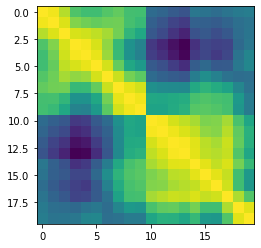

In [8]:
# This plots the correlation matrix ***
plt.imshow(cov['corr'])


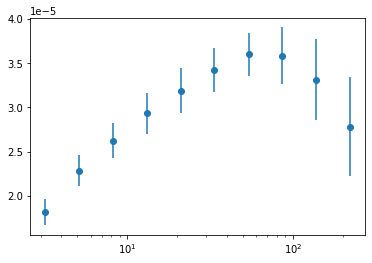

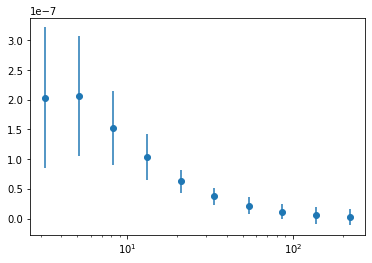

In [44]:
# this plot the average DV with errorbars:
v_ =  cov['mean'].reshape(-1,len(smoothing_scales))
err_ = np.sqrt(cov['cov'].diagonal()).reshape(-1,len(smoothing_scales))
for i in range(v_.shape[0]):
    plt.errorbar(smoothing_scales,v_[i]*smoothing_scales,err_[i]*smoothing_scales,fmt = 'o')
    plt.xscale('log')
    plt.show()

# Fisher matrix forecast

To read more about the fisher forecast:  https://wittman.physics.ucdavis.edu/Fisher-matrix-guide.pdf

In this Fisher forecast, we're just going to vary 2 cosmological aprameters; Omega_m and sigma_8.
You need to run PKDGRAV at two other cosmologies near the fiducial one (0.26,0.84). Ideally we'd like to just vary one cosmological parameter at a time; the way the sims have been run doesn't allow you to do this, but you can choose the sims at ( 0.2568,1.04) and (0.3109,0.8418), that's pretty close to what we need.

For these other simulations at a different cosmology, you also need to run your moments measurement. For each of those you have have 5 independent sims, which means you can have 20x independent measurements (you can cut 4 des y4 footprint for each of those). You'll have to run the code above, that loads the moments measurements and computes the covariance and average data vector for these two sets of simulations as well.

In [ ]:
bins_dictionary = dict()
bins_dictionary['kEkE'] = {'bins':[[2,2],[2,2,2]], 'scale_cut': None, 'Nz_mean': None} 
smoothing_scales = np.array([3.2,5.1,8.2,13.1,21.0,33.6,54.,86.,138,221.])


numb_of_real = 
cov,_,_ = make_covariance(mapp, numb_of_real, smoothing_scales, bins_dictionary)



# you basically need to load into memory the other two sets of sims
numb_of_real_p = 
cov_omega_p,_,_ = make_covariance(mapp_omega_p, numb_of_real_p, smoothing_scales, bins_dictionary['auto'])
cov_sigma_p,_,_ = make_covariance(mapp_simga_p, numb_of_real_p, smoothing_scales, bins_dictionary['auto'])


In [ ]:
# this is the variation on a given cosmological parameter in the two sets of sims
dom = (0.3109-0.26)
ds8 = (1.043-0.84)

# this is the difference in the data vectors over the difference in the cosmological parameters.
# Basically, it's an approximation for the derivative of the data vector wrt that parameter
d_xi_ds8 = (cov_sigma_p['mean']-cov['mean'])/ds8
d_xi_dom = (cov_omega_p['mean']-cov['mean'])/dom
       
# initialise fisher matrix
F = np.zeros((2,2))

mu = copy.copy(cov['cov'])
        #mu = 0.5*(mu+mu.T)
P = np.linalg.inv(mu)

F[1,1] = np.matmul(d_xi_ds8,np.matmul(P,d_xi_ds8)) 
F[0,0] = np.matmul(d_xi_dom,np.matmul(P,d_xi_dom)) 
F[0,1] = F[1,0] =  0.5*(np.matmul(d_xi_dom,np.matmul(P,d_xi_ds8)) +np.matmul(d_xi_ds8,np.matmul(P,d_xi_dom)) )
       

# The following lines transform the Fisher matrix from sigma_8,omegam to S8,omegam
omem = 0.3
sigma8 = 0.8
S8 = sigma8*np.sqrt(omem/0.3)
F1 = np.array([[ 1,  0.3*(1/sigma8)**2],
     [ -0.5*S8*(omem)**(3./2.)/0.3, 1./np.sqrt(omem/0.3)]]


In [ ]:
# this plots the results ****
import pylab as mplot
mplot.rc('text', usetex=False)
mplot.rc('font', family='serif')
import getdist
from getdist.gaussian_mixtures import GaussianND
from getdist import plots, MCSamples
import copy


chains_ = []



covariance = copy.deepcopy(F)
mean = [0.3, 0.8]#, 1] 


x = np.random.multivariate_normal(np.array([omem,S8]),covariance,30000)
sig8_ = np.array(x[:,1]).astype(np.float)
om_ = np.array(x[:,0]).astype(np.float)       
S8_ = sig8_*np.sqrt(om_/0.3)
mask = S8_ == S8_

ssa = np.c_[om_[mask].T,S8_[mask].T]
samples_ = MCSamples(samples=ssa,weights=np.ones(30000)[mask], names = ['Om','s8'], labels = [r'\Omega_{\rm m}','S_8'])

chains_.append(samples_)     
u = chains_.getParamNames()

    
g = plots.getSubplotPlotter(width_inch=7)



g.triangle_plot(chains_,['Om','s8'],filled=[False,False,False,False,False,False,True,True,True],legend_labels=['chain 1', 'chain 2', 'chain 3'],  contour_lws=[1.2,1.2,1.2,1.2,1.2,1.,1.],
                legend_loc='upper right',colors=[c_2,c_23,c_3,'black','black'],
                contour_ls =['-','-','-','-.','-'],contour_colors=[c_2,c_23,c_3,'black','black'],param_limits={'Om': [0.2,0.4], 
                       's8': [0.7,0.9]})





p = samples_.getParams()
print (ii)
print  ("Omega_m: {0:2.3f}+-{1:2.3f}".format(samples_.mean(p.Om),0.5*(samples_.twoTailLimits(p.Om, 0.68)[1]-samples_twoTailLimits(p.Om, 0.68)[0])))
print  ("S8 : {0:2.3f}+-{1:2.3f}".format(samples_.mean(p.s8),0.5*(samples_.twoTailLimits(p.s8, 0.68)[1]-samples_.twoTailLimits(p.s8, 0.68)[0])))
print ('')
    
plt.show()
